<a href="https://colab.research.google.com/github/astrfo/SRS-CH/blob/main/SRS_epsilon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRS-CH (ε 検証)

[満足化方策における非満足均衡を用いた確率的方策の検証] \\
https://www.jstage.jst.go.jp/article/pjsai/JSAI2021/0/JSAI2021_1G2GS2a04/_article/-char/ja/


[論文要約] \\
https://colab.research.google.com/drive/1PGbrYECAT7JiiOF_Zu0Sg8CzqjPTJE87#scrollTo=iaPmWlGNgFbd




In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import time
from decimal import Decimal, getcontext, FloatOperation, InvalidOperation, DivisionByZero

getcontext().traps[FloatOperation] = True
getcontext().traps[InvalidOperation] = False 
getcontext().traps[DivisionByZero] = False

%matplotlib inline

In [ ]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.random.rand(self._K)

    def play(self, arm):
        if self.prob[arm] > np.random.rand():
            return 1
        else:
            return 0

In [ ]:
class SRS_OPT1(object):
    """
    SRS-OPT
    """

    def __init__(self, K):
        self._epsilon = 1e-5
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.aleph = None
        self._rho = None
        self._Z = None
        self._b = None
        self._SRS = None
        self._pi = None

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self.aleph: cpV -= cpV.max() - self.aleph + self._epsilon
        self._n = np.array([self._epsilon] * self._K)
        self._N = np.sum(self._n)
        self._Z = 1 / (np.sum(1 / (self.aleph - cpV)))
        self._rho = self._Z / (self.aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

    def select_arm(self):
        arm = np.random.choice(len(self._pi), p=self._pi)
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self.aleph: cpV -= cpV.max() - self.aleph + self._epsilon
        self._n[arm] += 1
        self._N += 1
        self._Z = 1 / (np.sum(1 / (self.aleph - cpV)))
        self._rho = self._Z / (self.aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

In [ ]:
class SRS_OPT2(object):
    """
    SRS-OPT
    """

    def __init__(self, K):
        self._epsilon = 1e-6
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.aleph = None
        self._rho = None
        self._Z = None
        self._b = None
        self._SRS = None
        self._pi = None

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self.aleph: cpV -= cpV.max() - self.aleph + self._epsilon
        self._n = np.array([self._epsilon] * self._K)
        self._N = np.sum(self._n)
        self._Z = 1 / (np.sum(1 / (self.aleph - cpV)))
        self._rho = self._Z / (self.aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

    def select_arm(self):
        arm = np.random.choice(len(self._pi), p=self._pi)
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        cpV = copy.deepcopy(self._V)
        if self._V.max() > self.aleph: cpV -= cpV.max() - self.aleph + self._epsilon
        self._n[arm] += 1
        self._N += 1
        self._Z = 1 / (np.sum(1 / (self.aleph - cpV)))
        self._rho = self._Z / (self.aleph - cpV)
        self._b = self._n / self._rho - self._N + self._epsilon
        self._SRS = (self._N + self._b.max()) * self._rho - self._n
        self._pi = self._SRS / np.sum(self._SRS)

In [ ]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._policy = {SRS_OPT1(K): 'SRS-OPT', SRS_OPT2(K): 'SRS-OPT'}
        self._policy_plot_name = ['SRS-OPT(ε=1e-5)', 'SRS-OPT(ε=1e-6)']
        
        self._trial = trial
        self._step = step
        self._K = K
        self._env = None
        self._regret = np.zeros(self._step)
        self._regretV = None
        self.fig, self.ax = plt.subplots()

    def run(self):
        for policy, name in self._policy.items():
            start = time.time()
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                if name == 'RS' or name == 'SRS': policy.aleph = self._prob.max()
                elif name == 'RS-OPT' or name == 'SRS-OPT': policy.aleph = sum(sorted(self._prob, reverse=True)[:2]) / 2
                policy.initialize()
                self._regretV = 0.0
                for s in range(self._step):
                    arm = policy.select_arm()
                    reward = self._env.play(arm)
                    policy.update(arm, reward)
                    self.calc_regret(t, s, arm)
            elapsed_time = time.time() - start
            print(f'{name}: {elapsed_time}[sec]')
            self.print_regret()
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regretV += (self._prob.max() - self._prob[arm])
        self._regret[s] += (self._regretV - self._regret[s]) / (t+1)

    def print_regret(self):
        self.ax.plot(np.arange(self._step), self._regret)
        self.ax.set_title(f'sim: {self._trial}, step: {self._step}, K: {self._K}')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._policy_plot_name, loc="upper left")

SRS-OPT: 1.018538475036621[sec]
SRS-OPT: 1.0784037113189697[sec]


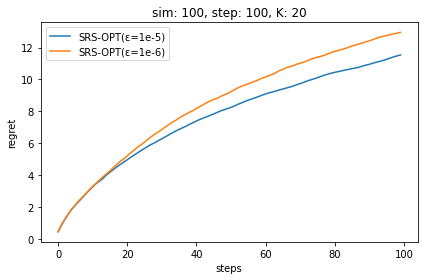

In [ ]:
def main():
    trial = 100
    step = 100
    K = 20
    sim = Simulator(trial, step, K)
    sim.run()

main()